<a href="https://colab.research.google.com/github/avimallick/Deep-Learning-Assignments/blob/master/19113015_DL_Exercise12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DEEP LEARNING ASSIGNMENT 12

## AVINASH MALLICK
## 19113015
## CSE-7A

# Pneumothorax Binary Classification

## Importing Libraries

In [ ]:
import numpy as np 
import pandas as pd 
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

from keras.preprocessing.image import load_img
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import BatchNormalization, Dense, GlobalAveragePooling2D,Lambda, Dropout, InputLayer, Input
from tensorflow import keras
from keras.applications import Xception
from keras.applications.xception import preprocess_input
from keras.callbacks import EarlyStopping
from keras.models import Sequential

## Importing The Dataset

In [ ]:
train_img_path = '../input/pneumothorax-binary-classification-task/small_train_data_set/small_train_data_set'
labels = pd.read_csv(r'../input/pneumothorax-binary-classification-task/train_data.csv')

Pneumothorax small dataset contains 2027 images medical images of lungs done by radiologist during chest x-ray of the patients.

In [ ]:
labels.head()

,Unnamed: 0,Unnamed: 0.1,file_name,target
0,6193,6193,1.2.276.0.7230010.3.1.4.8323329.491.1517875163...,1
1,377,377,1.2.276.0.7230010.3.1.4.8323329.14299.15178752...,1
2,9874,9874,1.2.276.0.7230010.3.1.4.8323329.1002.151787516...,1
3,4966,4966,1.2.276.0.7230010.3.1.4.8323329.4475.151787518...,1
4,5330,5330,1.2.276.0.7230010.3.1.4.8323329.3568.151787517...,1


In [ ]:
#drop unnecessary columns
labels.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1,inplace=True)

In [ ]:
print(f'Number of pictures in the training dataset: {labels.shape[0]}\n')
print(f'Number of different labels: {len(labels.target.unique())}\n')
print(f'Labels: {labels.target.unique()}')

Number of pictures in the training dataset: 2027

Number of different labels: 2

Labels: [1 0]


## Data Visualization

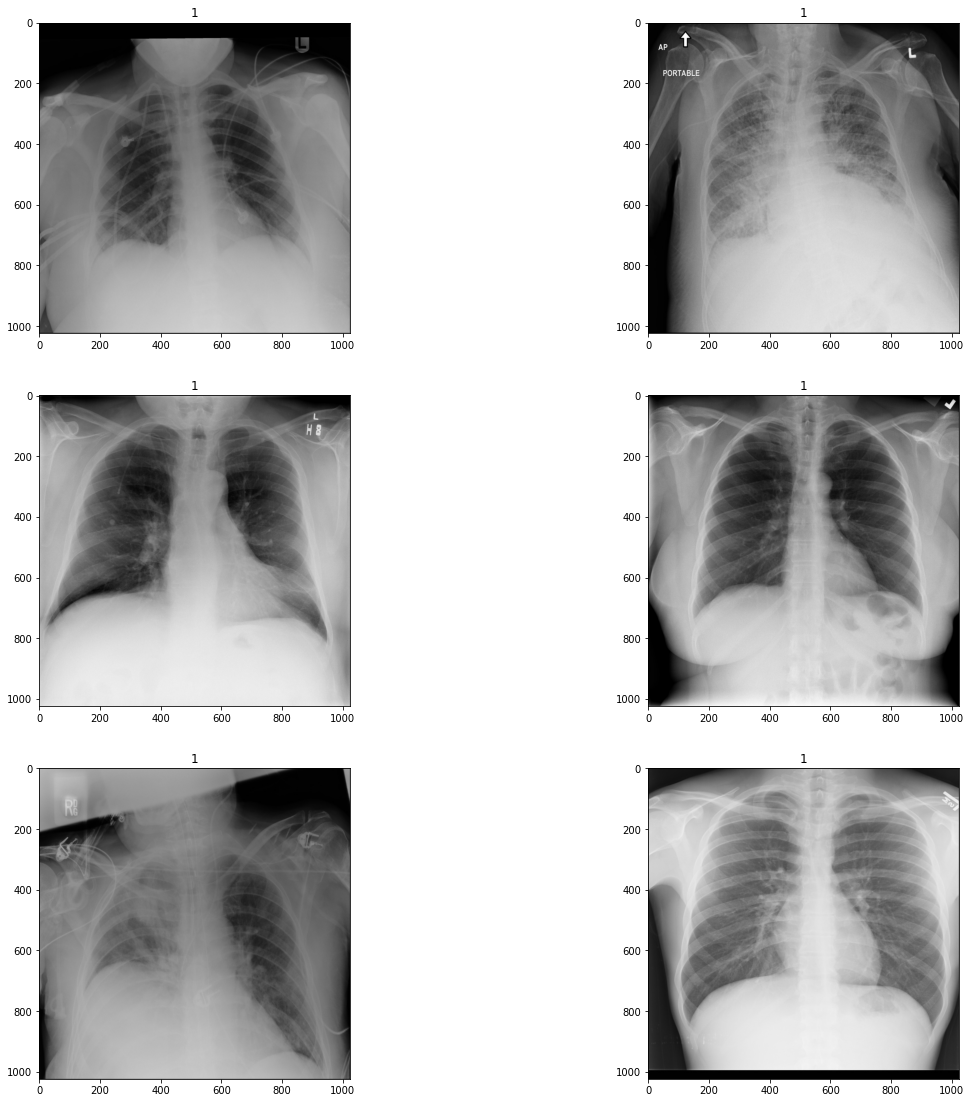

In [ ]:
plt.figure(figsize=(20,40))
i=1
for idx,s in labels.head(6).iterrows():
    img_path = os.path.join(train_img_path,s['file_name'])
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    fig=plt.subplot(6,2,i)
    fig.imshow(img)
    fig.set_title(s['target'])
    i+=1

In [ ]:
#Extracting different classes
classes = sorted(labels['target'].unique())
n_classes = len(classes)
print(f'number of class: {n_classes}')

number of class: 2


In [ ]:
classes_to_num = dict(zip(classes,range(n_classes)))

## Converting Images to Array

In [ ]:
#Function to load and convert images to array

def images_to_array(data_dir,df,image_size):
    image_names = df['file_name']
    image_labels = df['target']
    data_size = len(image_names)
    
    X = np.zeros([data_size,image_size[0],image_size[1],image_size[2]],dtype = np.uint8)
    y = np.zeros([data_size,1],dtype = np.uint8)
    
    for i in range(data_size):
        img_name = image_names[i]
        img_dir = os.path.join(data_dir,img_name)
        img_pixels = load_img(img_dir,target_size=image_size)
        X[i] = img_pixels
        y[i] = classes_to_num[image_labels[i]]
        
    y = to_categorical(y)
    ind = np.random.permutation(data_size)
    X = X[ind]
    y = y[ind]
    print('Ouptut Data Size: ', X.shape)
    print('Ouptut Label Size: ', y.shape)
    return X, y  


In [ ]:
#Selecting image size according to pretrained models
img_size = (299,299,3)
X, y = images_to_array(train_img_path,labels,img_size)

Ouptut Data Size:  (2027, 299, 299, 3)
Ouptut Label Size:  (2027, 2)


## Extracting features using Xception

In [ ]:

def get_features(model_name, data_preprocessor,weight, input_size, data):
    #Prepare pipeline.
    input_layer = Input(input_size)
    preprocessor = Lambda(data_preprocessor)(input_layer)
    
    base_model = model_name(weights=weight,
                            include_top=False,
                            input_shape=input_size)(preprocessor)
    
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = avg)
    
    #Extract feature.
    feature_maps = feature_extractor.predict(data, batch_size=128, verbose=1)
    print('Feature maps shape: ', feature_maps.shape)
    return feature_maps

In [ ]:
#Extracting features using Xception
Xception_preprocessor = preprocess_input
Xception_features = get_features(Xception,
                                  Xception_preprocessor,
                                 '../input/keras-pretrained-models/Xception_NoTop_ImageNet.h5',
                                  img_size, X)

16/16 [==============================] - 478s 30s/step
Feature maps shape:  (2027, 2048)


## Model Building

In [ ]:
#Callbacks
EarlyStop_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
my_callback=[EarlyStop_callback]

In [ ]:
#Adding the final layers to the above base models where the actual classification is done in the dense layers
#Building Model
model = Sequential()
model.add(InputLayer(Xception_features.shape[1:]))
model.add(Dropout(0.3))
model.add(Dense(2,activation='sigmoid'))

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['AUC'])
model.summary()

# Training the CNN on the Train features and evaluating it on the val data
history = model.fit(Xception_features,y,validation_split=0.20,callbacks=my_callback, epochs = 50, batch_size=128)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 4,098
Trainable params: 4,098
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
13/13 [==============================] - 2s 75ms/step - loss: 0.5645 - auc: 0.7722 - val_loss: 0.4980 - val_auc: 0.8336
Epoch 2/50
13/13 [==============================] - 0s 13ms/step - loss: 0.5068 - auc: 0.8190 - val_loss: 0.4581 - val_auc: 0.8613
Epoch 3/50
13/13 [==============================] - 0s 13ms/step - loss: 0.4655 - auc: 0.8480 - val_loss: 0.4493 - val_auc: 0.8715
Epoch 4/50
13/13 [==============================] - 0s 11ms/step - loss: 0.4430 - auc: 0.8689 - val_loss: 0.4408 - val_auc:

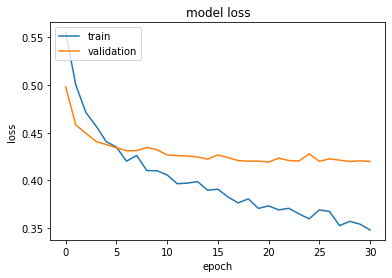

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

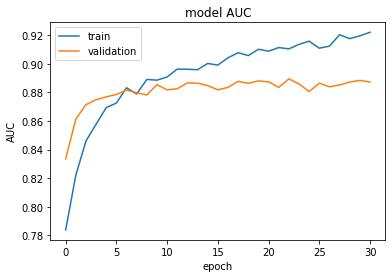

In [ ]:
# summarize history for AUC
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()